# Sentiment Analysis Using Simple RNN, LSTM, GRU, Bidirectional RNN


In [ ]:
%%bash
pip install keras
pip install bokeh
pip install git+https://github.com/tla/ipython-hierarchymagic

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
  Cloning https://github.com/tla/ipython-hierarchymagic to /tmp/pip-req-build-e34t6t0i
  Created wheel for ipython-hierarchymagic: filename=ipython_hierarchymagic-0.1-cp36-none-any.whl size=5025 sha256=630056bf595a7e12dc32ae3aaf166e75251f1d3077114a474dd26206268513cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5ak5mk9/wheels/32/77/29/9bb9c3340e84bcdaa481575d1d18e60857fc184ba89a34e5f6
Successfully built ipython-hierarchymagic




  Running command git clone -q https://github.com/tla/ipython-hierarchymagic /tmp/pip-req-build-e34t6t0i


In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook

In [ ]:
output_notebook()

### Defined Matplot lib for graph plotting.

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
import numpy as np
import pandas as pd

## Dataset

### 1) Movie Review Data
Keras IMDB dataset is used here.This dataset consist of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative).[Dataset Link](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification)

In [ ]:
from tensorflow.keras.datasets import imdb

In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


### Dataset Instances

In [ ]:
word_to_id = imdb.get_word_index()
INDEX_FROM=3
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0     #Padding
word_to_id["<START>"] = 1   #Start Index
word_to_id["<UNK>"] = 2     #Unknown Words
id_to_word = {value:key for key,value in word_to_id.items()}
for i in range(5):
  print("REVIEW",str(i+1),"\t",' '.join(id_to_word[id] for id in x_train[i] ))

REVIEW 1 	 <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amaz

Dictionary of words

In [ ]:
dictionary=word_to_id
len(dictionary)

88587

### 2) Hotel Review Dataset
I will also add another dataset to the existing training dataset. This dataset contains 515,000 customer reviews and scoring of 1493 luxury hotels across Europe. Meanwhile, the geographical location of hotels are also provided for further analysis.This dataset is fetched from [booking.com](https://www.booking.com/)

In [ ]:
!gdown --id 1e1SsVct7B6m3GLKlYKHb4ZGy8Ws4K35r --output 515k-hotel-reviews-data-in-europe.zip

In [ ]:
!unzip -q 515k-hotel-reviews-data-in-europe.zip

In [ ]:
!ls

515k-hotel-reviews-data-in-europe.zip  Hotel_Reviews.csv  sample_data


In [ ]:
df = pd.read_csv("Hotel_Reviews.csv", parse_dates=['Review_Date'])
df.shape

(515738, 17)

In [ ]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [ ]:
df["review"] = df["Negative_Review"] + df["Positive_Review"]
df["review_type"] = df["Reviewer_Score"].apply(
  lambda x: "Negative" if x < 7 else "Positive"
)

In [ ]:
df = df[["review", "review_type"]]

In [ ]:
df.review_type.value_counts()

Positive    428887
Negative     86851
Name: review_type, dtype: int64

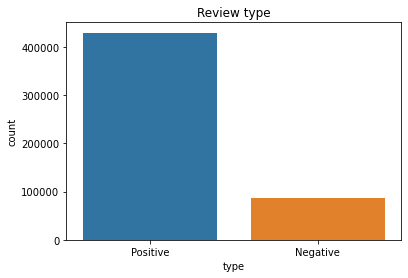

In [ ]:
import seaborn as sns
sns.countplot(
  x='review_type',
  data=df,
  order=df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type");

In [ ]:
df

,review,review_type
0,I am so angry that i made this post available...,Negative
1,No Negative No real complaints the hotel was g...,Positive
2,Rooms are nice but for elderly a bit difficul...,Positive
3,My room was dirty and I was afraid to walk ba...,Negative
4,You When I booked with your company on line y...,Negative
...,...,...
515733,no trolly or staff to help you take the lugga...,Positive
515734,The hotel looks like 3 but surely not 4 Brea...,Negative
515735,The ac was useless It was a hot week in vienn...,Negative
515736,No Negative The rooms are enormous and really ...,Positive


## Data Preprocessing

Blancing the hotel review dataset

In [ ]:
positive_reviews = df[df.review_type == "Positive"]
negative_reviews = df[df.review_type == "Negative"]

In [ ]:
RANDOM_SEED = 42
positive_df = positive_reviews.sample(n=len(negative_reviews), random_state=RANDOM_SEED)
negative_df = negative_reviews

In [ ]:
review_df = positive_df.append(negative_df).reset_index(drop=True)
review_df

,review,review_type
0,Nothing not to like Location was excellent r...,Positive
1,Replenishment of supplies in room toiletries ...,Positive
2,No Negative The views,Positive
3,Could do with biscuits and a complimentary wa...,Positive
4,Bar prices expensive and mini bar very expens...,Positive
...,...,...
173697,Wifi Location No tea or coffee in the room Ra...,Negative
173698,Everything Nothing,Negative
173699,no free parking the room was in another build...,Negative
173700,The hotel looks like 3 but surely not 4 Brea...,Negative


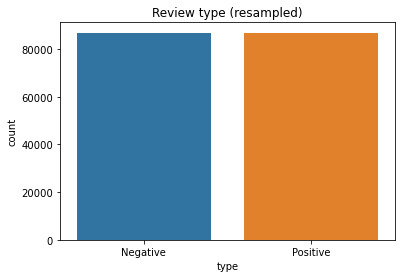

In [ ]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

Function to remove punctuations.

In [ ]:
from string import punctuation
def rem_punc(s):
  r=''.join([c for c in s if c not in punctuation])
  return r

Function to encode sentence using the word dictionary.

In [ ]:
def enc_sen(s):
  e=[1] #start
  wl=s.lower().strip().split(" ")
  for w in wl:
    if w in dictionary:
      e.append(dictionary[w])
    else:
      e.append(2) #Unknown
  return e

Function to encode labels { 1->Positive 0->Negative }.

In [ ]:
def enc_labels(l):
  d={'Positive':1,'Negative':0}
  a=np.array([d[x] for x in l])
  return a

Review dataframe to list.

In [ ]:
rev_list=list(review_df['review'])

In [ ]:
lab_list=list(review_df['review_type'])

Removing Punctuation

In [ ]:
rev_list=[rem_punc(x) for x in rev_list]
print("\n".join(rev_list[:5])) #Top five reviews in review list

 Nothing not to like  Location was excellent rooms were extremely comfortable well maintained Facilities within the hotel were great especially the lounge which was a perfect place to relax after a day of sightseeing 
 Replenishment of supplies in room toiletries tea coffee water etc was inconsistent Service in the Club Room was poor Hotel baggage labels left sticky residue on suitcase handles  very comfortable bed excellent air con great location problem with TV was promptly fixed 
No Negative The views
 Could do with biscuits and a complimentary water bottle in the room  Clean and comfortable room Kettle and selection of tea bags provided Excellent Wifi connection Croissants were nice I brought my own tea bags as tea in all the hotels is rubbish Near good restaurants including those serving Halal food Queensway underground is the nearest tube station Had lunch in Little Persia very good Near a park for walk and jog Be prepared to pay a deposit which you do get back in couple of days 

Encoding Sentences

In [ ]:
enc_rev=np.array([enc_sen(m) for m in rev_list])
enc_rev

array([list([1, 164, 24, 8, 40, 2, 1622, 16, 321, 4340, 71, 576, 3969, 73, 10302, 15413, 746, 4, 1455, 71, 87, 262, 4, 17269, 63, 16, 6, 404, 273, 8, 5206, 103, 6, 251, 7, 48763]),
       list([1, 2, 7, 9786, 11, 673, 73095, 3384, 4099, 1093, 525, 16, 5562, 2469, 11, 4, 1333, 673, 16, 338, 1455, 15655, 17510, 317, 13492, 29028, 23, 17797, 5931, 2, 55, 3969, 1445, 321, 945, 2697, 87, 1622, 439, 19, 248, 16, 6287, 8533]),
       list([1, 57, 1566, 4, 2692]), ...,
       list([1, 57, 879, 7047, 4, 673, 16, 11, 160, 1430, 359, 8, 6389, 4, 1430, 18, 6121, 42, 9496, 2, 1058, 673]),
       list([1, 4, 1455, 272, 40, 342, 21, 1348, 24, 470, 2, 6121, 16, 608, 5, 75, 188, 908, 808, 11]),
       list([1, 4, 31157, 16, 3506, 12, 16, 6, 893, 1269, 11, 9042, 5, 12, 64, 520, 53, 893, 2, 1123])],
      dtype=object)

Encoding Labels

In [ ]:
enc_labs=enc_labels(lab_list)
enc_labs

array([1, 1, 1, ..., 0, 0, 0])

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(
    enc_rev,
    enc_labs,
    test_size=.1,
    random_state=RANDOM_SEED
  )

In [ ]:
print(x_train1.shape)
print(x_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(156331,)
(17371,)
(156331,)
(17371,)


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


Concatenating the test and train sets of both datasets

In [ ]:
x_train=np.concatenate((x_train,x_train1))
x_test=np.concatenate((x_test,x_test1))
y_train=np.concatenate((y_train,y_train1))
y_test=np.concatenate((y_test,y_test1))

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(181331,)
(42371,)
(181331,)
(42371,)


The RNN takes sequences of constant length. This length is the `words_limit` which is defined to be 100. Since the reviews differ heavily in terms of lengths, I'm trimming each review to its first 200 words. If reviews are shorter than 200 words they will be padded with zeros.

In [ ]:
words_limit=200

In [ ]:
import random
import json
from six.moves import range
import six

Function to pad sequences to word_limit

In [ ]:
def pad_sequences(sequences, maxlen=None):

    dtype='int32';padding='pre';truncating='pre';value=0.
    num_samples = len(sequences)

    lengths = []
    sample_shape = ()
    flag = True

    # take the sample shape from the first non empty sequence
    # checking for consistency in the main loop below.

    for x in sequences:
        try:
            lengths.append(len(x))
            if flag and len(x):
                sample_shape = np.asarray(x).shape[1:]
                flag = False
        except TypeError:
            raise ValueError('`sequences` must be a list of iterables. '
                             'Found non-iterable: ' + str(x))

    if maxlen is None:
        maxlen = np.max(lengths)

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(dtype, np.unicode_)

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == 'pre':
            trunc = s[-maxlen:]
        elif truncating == 'post':
            trunc = s[:maxlen]
        trunc = np.asarray(trunc, dtype=dtype)

        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
    return x

Padding the sequences

In [ ]:
x_train_seq = pad_sequences(x_train, maxlen=words_limit)
x_test_seq = pad_sequences(x_test, maxlen=words_limit)

print('train shape:', x_train_seq.shape)
print('test shape:', x_test_seq.shape)

train shape: (181331, 200)
test shape: (42371, 200)


In [ ]:
x_train_seq

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,   30,   57, 1123],
       [   0,    0,    0, ...,  525,    2, 1622],
       [   0,    0,    0, ..., 3477,  313, 1622]])

Keras Models and Layers

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Activation, Input, LSTM, GRU, Bidirectional

## RNN Model for Sentiment Analysis


In [ ]:
rnn_input = Input(shape=(words_limit,))
embedding = Embedding(len(dictionary), 128, input_length=words_limit)(rnn_input)
simple_rnn = SimpleRNN(128)(embedding)
dropout = Dropout(0.4)(simple_rnn)
dense = Dense(1)(dropout)
activation = Activation('sigmoid')(dense)
model1 = Model(rnn_input, activation)


In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          11339136  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 11,372,161
Trainable params: 11,372,161
Non-trainable params: 0
_________________________________________________

Optimizer: Adam and Loss Model: Binary CrossEntropy

In [ ]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Creating checkpoints to save best model

In [ ]:
import os
checkpoint_path_rnn = "rnn_model.h5"
checkpoint_dir = os.path.dirname(checkpoint_path_rnn)


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_rnn,
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
history=model1.fit(x_train_seq, y_train, batch_size=32, epochs=10, validation_data=(x_test_seq, y_test),callbacks=[cp_callback])

Train on 181331 samples, validate on 42371 samples
Epoch 1/10
181312/181331 [============================>.] - ETA: 0s - loss: 0.5314 - accuracy: 0.7380
Epoch 00001: val_loss improved from inf to 0.53880, saving model to rnn_model.h5
181331/181331 [==============================] - 2008s 11ms/sample - loss: 0.5314 - accuracy: 0.7380 - val_loss: 0.5388 - val_accuracy: 0.7474
Epoch 2/10
181312/181331 [============================>.] - ETA: 0s - loss: 0.5589 - accuracy: 0.7168
Epoch 00002: val_loss did not improve from 0.53880
181331/181331 [==============================] - 2519s 14ms/sample - loss: 0.5589 - accuracy: 0.7168 - val_loss: 0.5438 - val_accuracy: 0.7356
Epoch 3/10
181312/181331 [============================>.] - ETA: 0s - loss: 0.5136 - accuracy: 0.7545
Epoch 00003: val_loss improved from 0.53880 to 0.53625, saving model to rnn_model.h5
181331/181331 [==============================] - 1498s 8ms/sample - loss: 0.5136 - accuracy: 0.7545 - val_loss: 0.5362 - val_accuracy: 0.746

## Performance Measure of the model

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
for j in history.history.keys():
    print(history.history[j])

[0.531369426853029, 0.5588998254588157, 0.5135641423637293, 0.4945417375003434, 0.4770536645718926, 0.49114742403947986, 0.5124615855987231, 0.5010117735360587, 0.4655440109622781, 0.47058699263674547]
[0.738026, 0.71678865, 0.7544932, 0.76858896, 0.7810082, 0.7703371, 0.7556127, 0.7639124, 0.7892583, 0.788773]
[0.5388001862942647, 0.5437785323440827, 0.5362465779150731, 0.5057486512125803, 0.5820401028962372, 0.5206168404107097, 0.6113965009132738, 0.5409165925396495, 0.5529002354977892, 0.5352788440472921]
[0.74744517, 0.73559743, 0.74617076, 0.7785042, 0.71574897, 0.7420406, 0.6484624, 0.73571545, 0.7389488, 0.7391376]


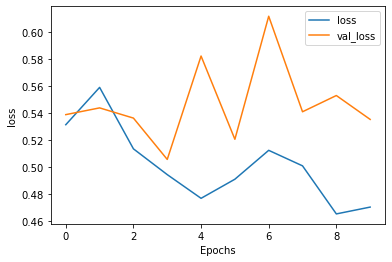

In [ ]:
plot_graphs(history,'loss')

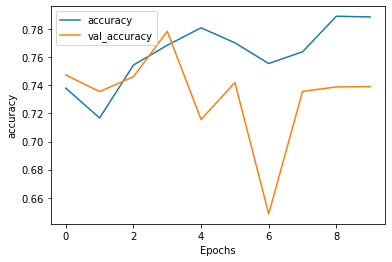

In [ ]:
plot_graphs(history,'accuracy')

In [ ]:
p = figure(title="Loss History", x_axis_label='Time', y_axis_label='Loss')
range(len(history.history['val_loss']))
p.line(range(len(history.history['val_loss'])), history.history['val_loss'],
       legend="Val. Loss", line_width=2, line_color='orange')
p.line(range(len(history.history['loss'])), history.history['loss'],
       legend="Loss", line_width=2, line_color='blue')

GlyphRenderer(id='1051', ...)

In [ ]:
output_notebook()
show(p)

In [ ]:
p = figure(title="Accuracy History", x_axis_label='Time', y_axis_label='Loss')
p.line(range(len(history.history['val_accuracy'])), history.history['val_accuracy'],
       legend="Val. Acc", line_width=2, line_color='orange')
p.line(range(len(history.history['accuracy'])), history.history['accuracy'],
       legend="Acc", line_width=2, line_color='blue')
output_notebook()
show(p)

## Loading the Model

In [ ]:
Loaded_model1 = tf.keras.models.load_model(
    checkpoint_path_rnn
)

## Loss Score and Accuracy

In [ ]:
score, acc = Loaded_model1.evaluate(x_test_seq, y_test, batch_size=32, verbose=0)
print("Loss Score: ",score)
print("Accuracy: ",acc)

Loss Score:  0.5057486512125803
Accuracy:  0.7785042


## Confusion Matrix

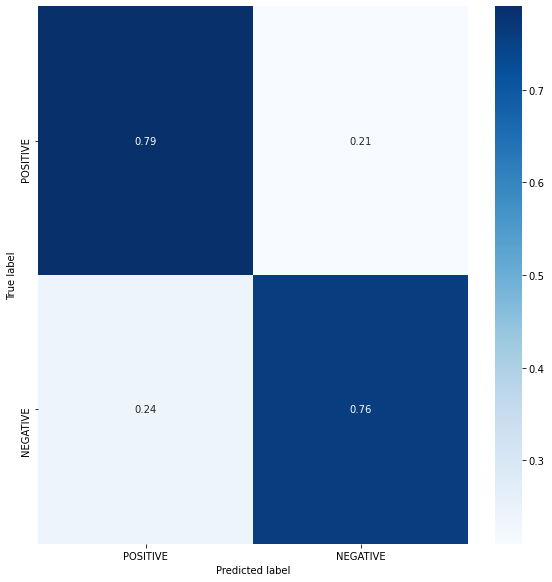

In [ ]:
y_pred=Loaded_model1.predict(x_test_seq)
y_pred=[1 if x>=0.5 else 0 for x in y_pred]
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = ['POSITIVE','NEGATIVE'],
                     columns = ['POSITIVE','NEGATIVE'])
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()